In [1]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import jax
import jax.numpy as jnp
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.distributions import MultivariateNormal

from uncprop.core.distribution import GaussianFromNumpyro
from uncprop.core.samplers import sample_distribution
from uncprop.utils.plot import set_plot_theme, smart_subplots
from uncprop.utils.grid import plot_coverage_curve_reps
from uncprop.models.elliptic_pde.inverse_problem import (
    PDESettings,
    generate_pde_inv_prob_rep,
    plot_inverse_problem_setup,
)

colors = set_plot_theme()
base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')

from pde_model import (
    get_discrete_source, 
    solve_pde, 
    solve_pde_vmap,
)

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# settings 

key = jr.key(5232214)
noise_sd = 1e-2
n_kl_modes = 6
obs_locations = jnp.array([10, 30, 60, 75])

inv_prob_settings = {
    'noise_cov' : noise_sd**2 * jnp.identity(len(obs_locations)),
    'n_kl_modes': n_kl_modes,
    'obs_locations': obs_locations,
    'settings': PDESettings()
}
inv_prob_settings['key'] = key

In [3]:
posterior, gp_prior, eig_info, ground_truth = generate_pde_inv_prob_rep(**inv_prob_settings)

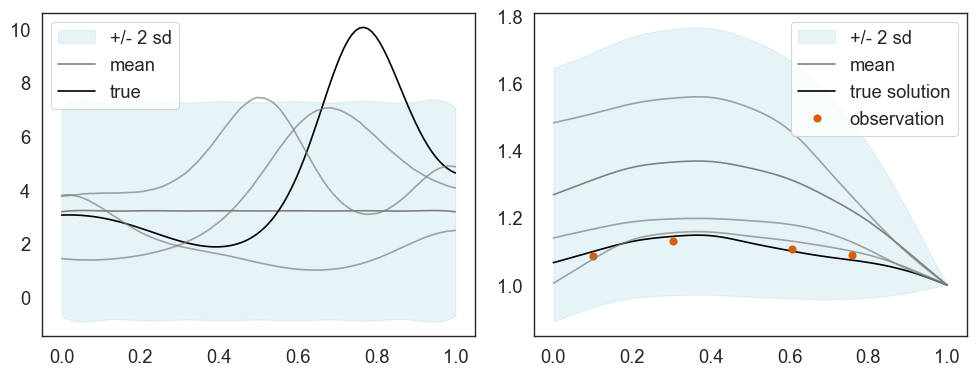

In [4]:
key, key_plot = jr.split(key)

fig, ax = plot_inverse_problem_setup(key=key_plot,
                                     posterior=posterior,
                                     ground_truth=ground_truth,
                                     observation=posterior.likelihood.observation,
                                     n_samp=3)

In [5]:
key, key_prior, key_mcmc = jr.split(key, 3)

positions, states, warmup_samp, prop_cov = sample_distribution(
    key=key,
    dist=posterior,
    initial_position=posterior.prior.sample(key_prior).squeeze(),
    n_samples=10_000,
    n_warmup=10_000
)

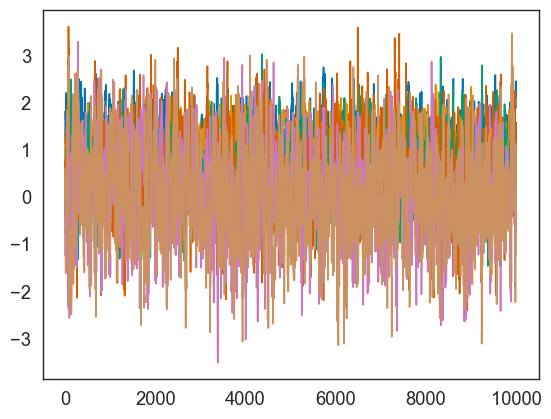

In [6]:
for i in range(posterior.dim):
    plt.plot(positions[:,i])

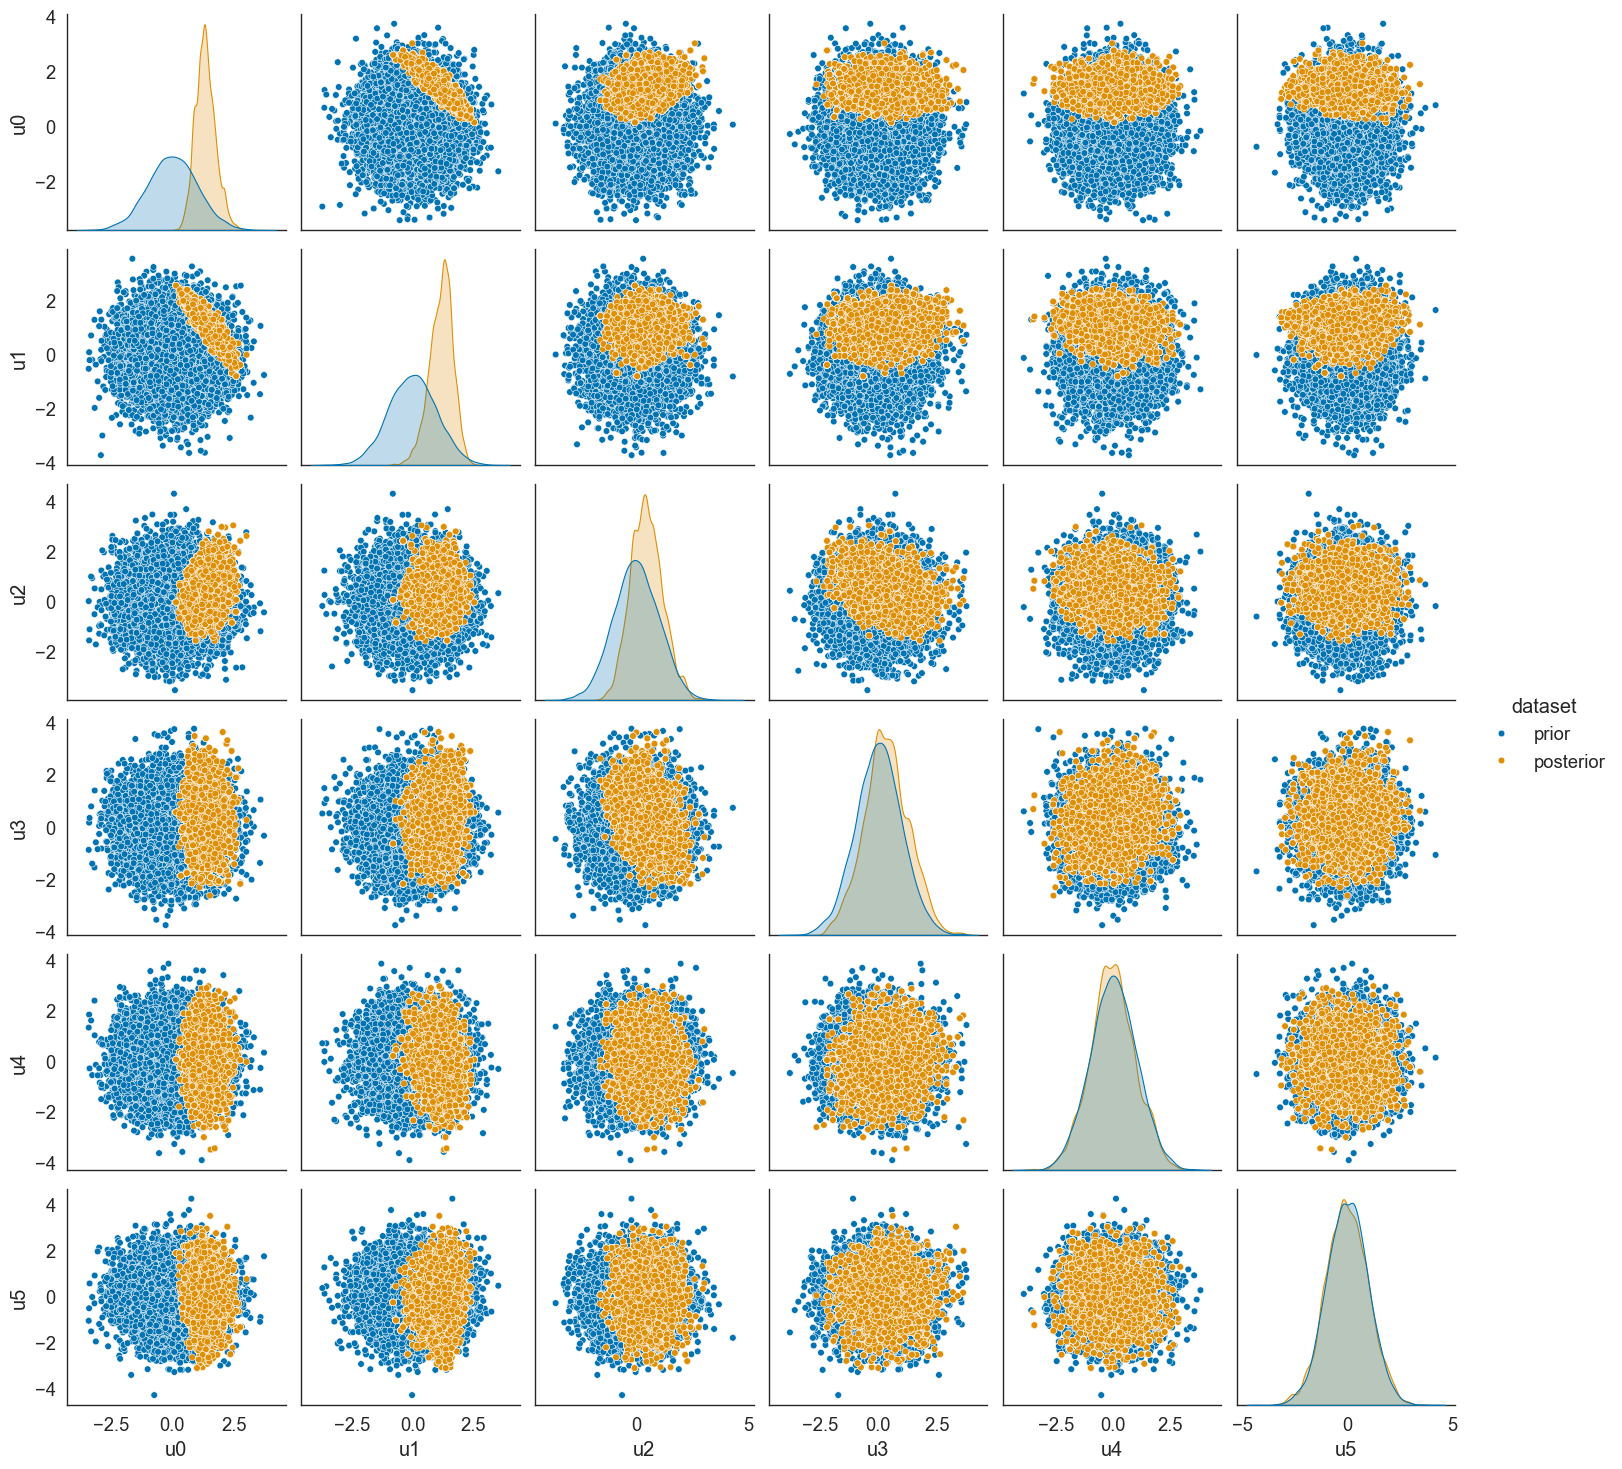

In [ ]:
key_idx, key_prior_samp, key = jr.split(key, 3)

idx = jr.choice(key_idx, positions.shape[0], (10_000,))
post_samp_df = pd.DataFrame(positions[idx], columns=posterior.prior.par_names)
prior_samp_df = pd.DataFrame(posterior.prior.sample(key_prior_samp, n=10_000), columns=posterior.prior.par_names)

post_samp_df['dataset'] = 'posterior'
prior_samp_df['dataset'] = 'prior'
samp_df = pd.concat([prior_samp_df, post_samp_df], ignore_index=True)

sns.pairplot(samp_df, hue='dataset')

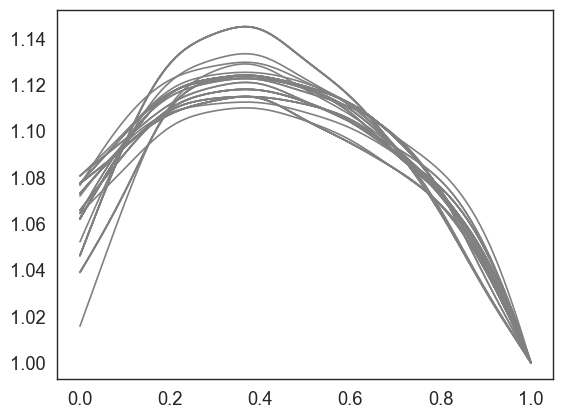

In [9]:
postsamp = positions[-50:,:]
param, log_field, pde_solution, observable = posterior.likelihood.forward_model.forward_with_intermediates(postsamp)
xgrid = posterior.likelihood.forward_model.pde_settings.xgrid

plt.plot(xgrid, pde_solution.T, color='gray')
plt.show()
